### 1D Photonic crystal

In [3]:
from Electromagnetics.FDTD import *
import numpy as np
import time, sys

n_dim = 1
r0, r1, dr = [None]*3
S = 0.9
n_t = None
save_every = 1
omega_min = 0.0
omega_max = 1.5*2.0*np.pi
omega = (omega_min + omega_max)/2.0

eps_arr = np.array([1.0, 10.0, 1.0])
d_arr = np.array([0.1, 0.1, 0.1])
exclude_bound = [False, True, False]
L_tot = sum(d_arr)
L_0 = 2.0*np.pi/omega

omega_imag = 0.001/L_tot
t_max = 2.0*np.pi/omega_imag

r0 = np.array([0.0])
r1 = np.array([L_tot])
dr = np.array([L_tot/30])
    
dt = S*dr[0]
d_v = np.prod(dr)
n_t = int(2**int(np.log2(t_max/dt)+1.0))
print('n_t: ', n_t)
sys.stdout.flush()

## fdtd simulator
fdtd = FDTDSimulator(dtype=complex)

fdtd.SetSimulationBox(r0, r1, dr, dt)
fdtd.save_every = save_every 

## set PBC
k_max = np.pi/L_tot
print('k_max: ', k_max)
fdtd.SetBCs(FVTypes.PBC)
k_vec = np.array([0.0*k_max])
fdtd.SetKVec(k_vec)

## J
alpha = (omega_max-omega_min)/2.0
t_0 = 3.0/alpha
f_t = lambda t: np.sin(omega*(t-t_0))*np.exp(-alpha**2*(t-t_0)**2)
#f_t = lambda t: np.sinc(alpha*(t-t_0))

r_j0 = r0 #+ np.array([d_arr[0]/2.0])
r_j1 = r1
je_mag = lambda r: 1.0/dr[0]*np.exp(-1j*k_vec*(r-r_j0))
src_dir = 'z'
je_args = None
je_type = FVTypes.JeBox
je_args = {'r0':r_j0, 'r1':r_j1, 'mag':je_mag, 'f_t':f_t, 'src_dir':src_dir}

fdtd.AddSources({'type':je_type, 'name':'Je', 'args':je_args})

## epsilon_r
x_eps = np.zeros(len(eps_arr)+1)
x_eps[0] = r0[0]
for i in range(len(eps_arr)):
    x_eps[i+1] = x_eps[i] + d_arr[i] 
    eps_args = {'r0':np.array([x_eps[i]]), 'r1':np.array([x_eps[i+1]]), 'mag_in':eps_arr[i], 'mag_out':0.0, 'exclude':exclude_bound[i]}
    fdtd.AddMaterial({'type':FVTypes.EpsIsoBox, 'name':'eps_{}'.format(i), 'args':eps_args})

## view planes
fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r0, 'args':{'A':'E', 'A_dir':'z', 'O_dir':None, 'name':'E'}})        
fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r0, 'args':{'A':'D', 'A_dir':'z', 'O_dir':None, 'name':'D'}})        

fdtd.StepFields(n_t)
n_saved = fdtd.n_saved
 

n_t:  262144
k_max:  10.471975512
simulation time: 1:52


Populating the interactive namespace from numpy and matplotlib
max(e_max): 5.74938573518


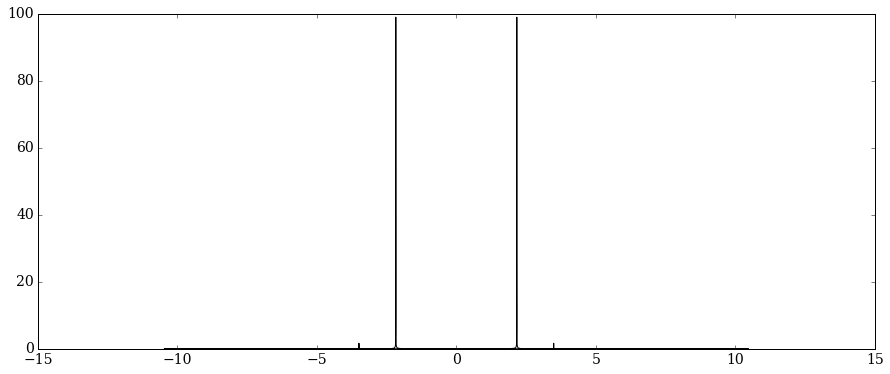

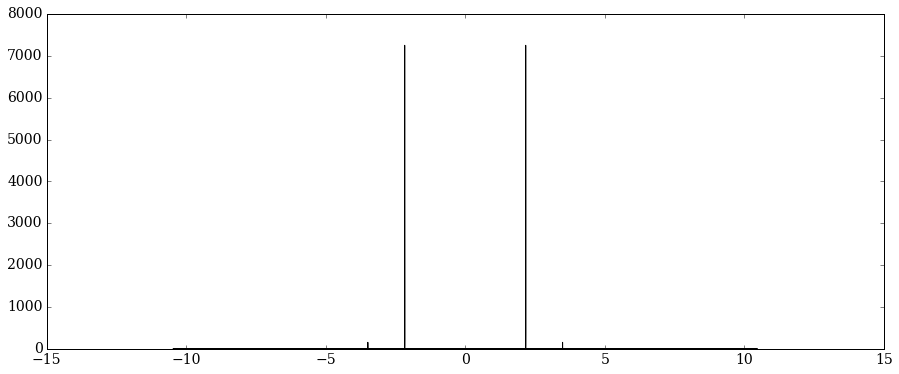

corr_max:  99.0451431403
[ 2.16844347  3.490448   -3.490448   -2.16844347]


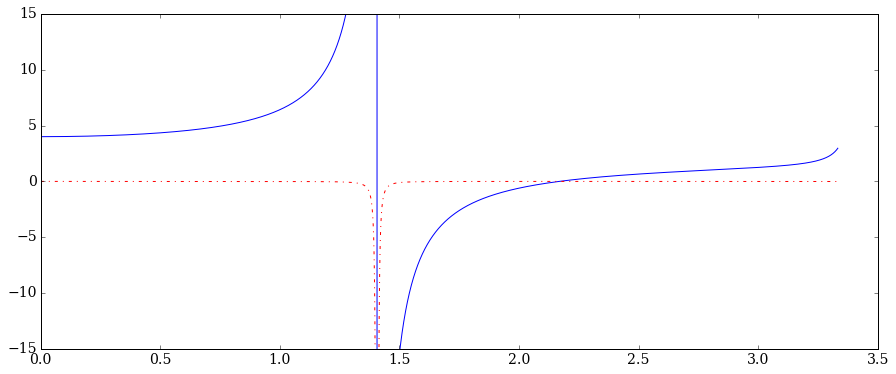

In [4]:
animate = False
if animate:
    %matplotlib wx
else:
    %pylab inline
    
import matplotlib.pyplot as plt

r_E, E_out_list = fdtd.GetOutputs('E')
r_E, D_out_list = fdtd.GetOutputs('D')
x_E = r_E[0]
e_max = [np.max(np.abs(e)) for e in E_out_list]
print('max(e_max):', max(e_max))
e_max = max(e_max)
N_x = len(x_E)

##---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib

plt_field = 'E'
save_anim = False
file_format = 'gif'   ## 'gif' / 'mp4'

use_subplots = False

font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 14}
matplotlib.rc('font', **font)

fig, axarr = None, None
def animate_E(i):
    plt.clf()
    fig = plt.plot(x_E, np.real(E_out_list[i]), 'b-.')
    fig = plt.plot(x_E, np.imag(E_out_list[i]), 'r-.')
    fig = plt.plot(x_E, np.abs(E_out_list[i]), 'k')
    axes = plt.gca()
    axes.set_ylim([-e_max, e_max])
    return fig

anim = None
fig = plt.figure()

if animate and plt_field=='E':
    anim = animation.FuncAnimation(fig, animate_E, frames=n_saved, interval=100)

    if save_anim:
        if file_format=='gif':
            anim.save('other/e-1d.gif', writer="imagemagick", fps=15, dpi=200)
        elif file_format=='mp4':
            anim.save('other/e-1d.mp4', writer="mencoder", fps=15, dpi=200)

    plt.show()
    
    ##-- fft
    n_rep = 1
    rt_shape = (len(x_E)*n_rep, len(E_out_list))
    print('rt_shape:', rt_shape)

    E_rt = np.zeros(rt_shape, dtype=complex)
    for i in range(len(E_out_list)):
        for j in range(n_rep):
            E_rt[j*N_x: (j+1)*N_x, i] = E_out_list[i]

    E_rt_fft = np.fft.fftshift(np.fft.fft2(E_rt))
    im = plt.imshow(np.abs(E_rt_fft).T, origin='lower', aspect='auto')
    plt.colorbar(im)
    plt.show()


if not animate:
    figsize(15, 6)
    plt.show()

## autocorrelation
E_0 = je_mag(x_E)
E_corr = np.zeros(n_saved, dtype=complex)
for i in range(n_saved):
    E_corr[i] = E_0.dot(np.conjugate(E_out_list[i]))/N_x
E_corr_fft = np.fft.fft(E_corr)/n_saved
freq_fft = np.fft.fftfreq(n_saved, d=dt)

f_cut = np.abs(freq_fft)<k_max
freq_fft = freq_fft[f_cut]
E_corr_fft = E_corr_fft[f_cut]
plt.plot(freq_fft, np.abs(E_corr_fft), 'k')
plt.show()
figsize(15, 6)

## peaks
dx = x_E[1]-x_E[0]
n_f = len(freq_fft)
E_corr_fft_diff = np.zeros(n_f, dtype=complex)
E_corr_fft_diff[:-1] = (np.abs(E_corr_fft)[1:] - np.abs(E_corr_fft)[:-1])/dx
plt.plot(freq_fft, np.abs(E_corr_fft_diff), 'k')
plt.show()

th_ratio = 1.0/1000.0
corr_max = np.max(np.abs(E_corr_fft))
print('corr_max: ', corr_max)
peaks = np.abs(E_corr_fft)>corr_max*th_ratio

Ecd_sign = np.sign(E_corr_fft_diff)
signchange = np.zeros(n_f, dtype=bool)
signchange[1:] = ((Ecd_sign[1:] - Ecd_sign[:-1]) < 0)
peak_sign_change = peaks*signchange

print(freq_fft[peak_sign_change])


##average
from scipy.integrate import simps
dx = x_E[1]-x_E[0]
_n_t_ = n_saved
E_avg = np.zeros(_n_t_, dtype=complex)
D_avg = np.zeros(_n_t_, dtype=complex)
for i in range(_n_t_):
    E_avg[i] = simps(E_out_list[i]*np.exp(+1j*k_vec[0]*x_E), dx=dx)
    D_avg[i] = simps(D_out_list[i]*np.exp(+1j*k_vec[0]*x_E), dx=dx)
    #E_avg[i] = simps(E_out_list[i], dx=dx)
    #D_avg[i] = simps(D_out_list[i], dx=dx)


t_arr = np.linspace(0, n_t*dt, _n_t_)
E_avg_f = np.fft.fft(E_avg*np.exp(-omega_imag*t_arr))/_n_t_
D_avg_f = np.fft.fft(D_avg)/_n_t_
eps_f = D_avg_f/E_avg_f
freq_f = np.fft.fftfreq(n_saved, d=dt)

f_cut = (freq_f>0.0) * (np.abs(freq_f)<1.0/L_tot)
freq_f = freq_f[f_cut]
eps_f = eps_f[f_cut]

plt.plot(freq_f, np.real(eps_f), 'b')
plt.plot(freq_f, np.imag(eps_f), 'r-.')
plt.gca().set_ylim([-15.0, 15.0])
plt.show()
    

In [11]:
## Permittiity and Permeability
def GetEps(fdtd, f_max):
    r_E, E_out_list = fdtd.GetOutputs('E')
    r_E, D_out_list = fdtd.GetOutputs('D')
    x_E = r_E[0]
    
    dx = x_E[1]-x_E[0]
    _n_t_ = fdtd.n_saved
    E_avg = np.zeros(_n_t_, dtype=complex)
    D_avg = np.zeros(_n_t_, dtype=complex)
    for i in range(_n_t_):
        E_avg[i] = simps(E_out_list[i]*np.exp(+1j*k_vec[0]*x_E), dx=dx)
        D_avg[i] = simps(D_out_list[i]*np.exp(+1j*k_vec[0]*x_E), dx=dx)
        #E_avg[i] = simps(E_out_list[i], dx=dx)
        #D_avg[i] = simps(D_out_list[i], dx=dx)


    t_arr = np.linspace(0, n_t*dt, _n_t_)
    E_avg_f = np.fft.fft(E_avg*np.exp(-omega_imag*t_arr))/_n_t_
    D_avg_f = np.fft.fft(D_avg)/_n_t_
    eps_f = D_avg_f/E_avg_f
    freq_f = np.fft.fftfreq(n_saved, d=dt)

    f_cut = (freq_f>0.0) * (np.abs(freq_f)<f_max)
    freq_f = freq_f[f_cut]
    eps_f = eps_f[f_cut]
    return [freq_f, eps_f]

n_k = 3
k = np.linspace(0.0, 0.1, n_k)*k_max
f_max = 1.0/L_tot
eps_f_k = [None]*n_k
freq_f_k = [None]*n_k
for i in range(n_k):
    fdtd.fdtd = None
    k_vec = np.array([k[i]])
    fdtd.SetKVec(k_vec)
    fdtd.StepFields(n_t)
    freq_f_k[i], eps_f_k[i] = GetEps(fdtd, f_max)



simulation time: 1:49
simulation time: 1:48
simulation time: 1:48


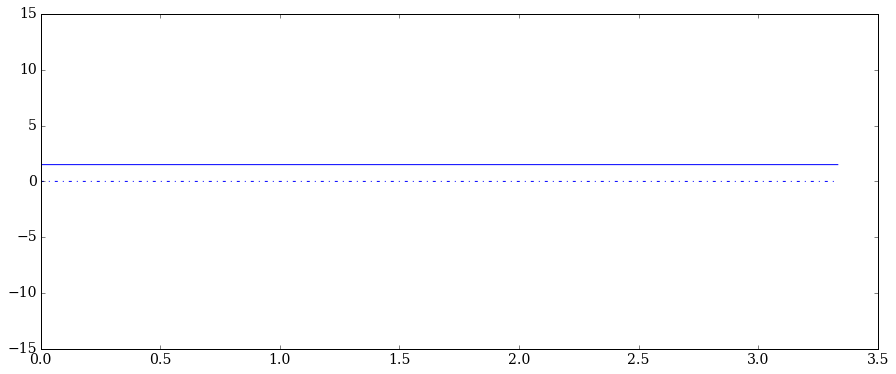

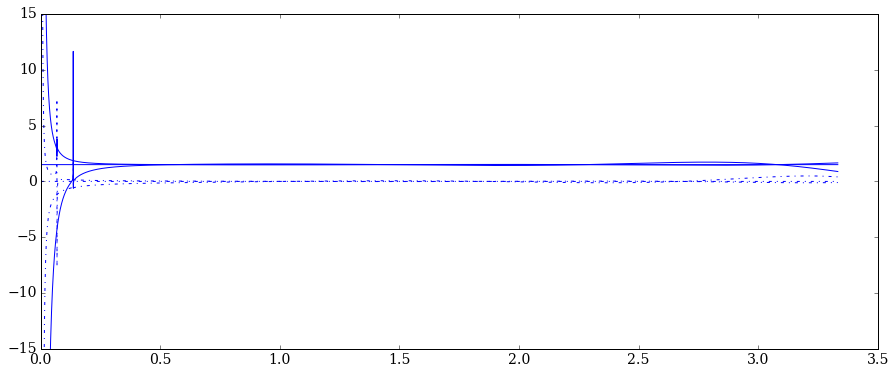

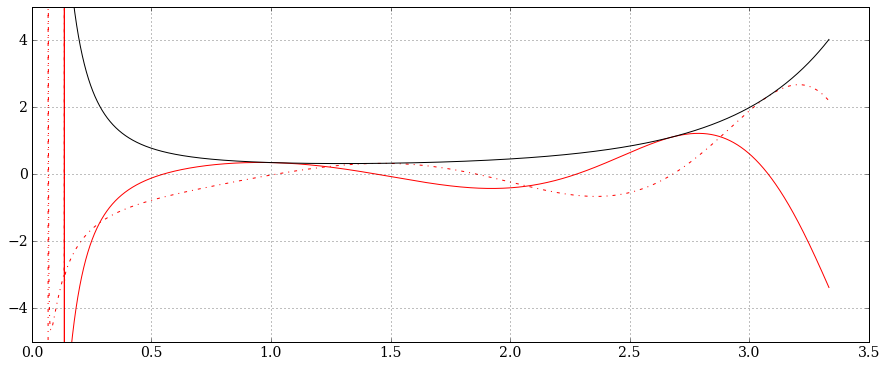

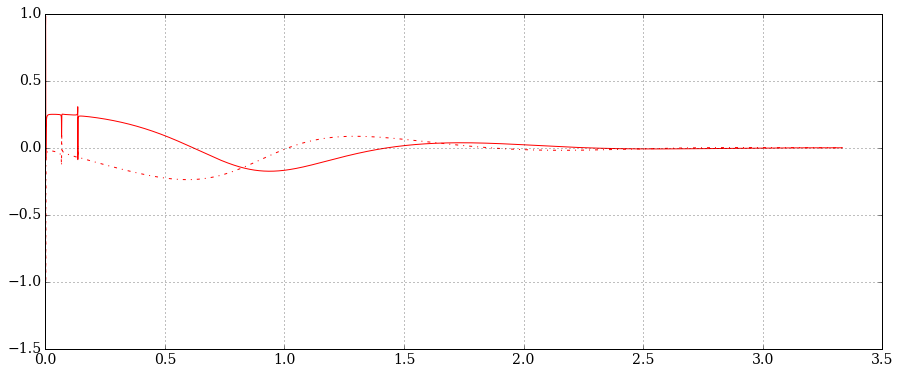

In [13]:

freq_f = freq_f_k[0]
eps_f = eps_f_k[0]
eps_fk__eps_f0 = [eps_f_k[i]-eps_f for i in range(3)]
dk2_eps_r = (eps_f_k[2] - 2.0*eps_f_k[1] + eps_f_k[0])/(k[1]-k[0])**2
#dk2_eps_r = (eps_fk__eps_f0[2] - 2.0*eps_fk__eps_f0[1] + eps_fk__eps_f0[0])/(k[1]-k[0])**2
mu_f = 1.0/(1.0 - (2.0*np.pi*freq_f)**2/2.0*dk2_eps_r)

plt.plot(freq_f, np.real(eps_f), 'b')
plt.plot(freq_f, np.imag(eps_f), 'b-.')
plt.gca().set_ylim([-15.0, 15.0])
plt.show()

for i in range(3):
    plt.plot(freq_f, np.real(eps_f_k[i]), 'b')
    plt.plot(freq_f, np.imag(eps_f_k[i]), 'b-.')
    plt.gca().set_ylim([-15.0, 15.0])
plt.show()

plt.plot(freq_f, np.real(dk2_eps_r), 'r')
plt.plot(freq_f, np.imag(dk2_eps_r), 'r-.')
plt.plot(freq_f, np.abs(dk2_eps_r), 'k')
plt.gca().set_ylim([-5.0, 5.0])
plt.grid()
plt.show()

plt.plot(freq_f, np.real(mu_f), 'r')
plt.plot(freq_f, np.imag(mu_f), 'r-.')
#plt.gca().set_ylim([-5.0, 5.0])
plt.grid()
plt.show()


In [6]:
def GetPeaks(fdtd):
    r_E, E_out_list = fdtd.GetOutputs('E')
    x_E = r_E[0]
    ##
    E_0 = je_mag(x_E)
    E_corr = np.zeros(n_saved, dtype=complex)
    for i in range(n_saved):
        E_corr[i] = E_0.dot(np.conjugate(E_out_list[i]))/N_x
    E_corr_fft = np.fft.fft(E_corr)/n_saved
    freq_fft = np.fft.fftfreq(n_saved, d=dt)
    ##
    f_cut = (np.abs(freq_fft)<k_max) * (freq_fft>=0.0)
    freq_fft = freq_fft[f_cut]
    E_corr_fft = E_corr_fft[f_cut]
    ##
    dx = x_E[1]-x_E[0]
    n_f = len(freq_fft)
    E_corr_fft_diff = np.zeros(n_f, dtype=complex)
    E_corr_fft_diff[:-1] = (np.abs(E_corr_fft)[1:] - np.abs(E_corr_fft)[:-1])/dx
    ##
    corr_max = np.max(np.abs(E_corr_fft))
    peaks = np.abs(E_corr_fft)>corr_max*th_ratio
    ##
    Ecd_sign = np.sign(E_corr_fft_diff)
    signchange = np.zeros(n_f, dtype=bool)
    signchange[1:] = ((Ecd_sign[1:] - Ecd_sign[:-1]) != 0)
    peak_sign_change = peaks*signchange
    ##
    return freq_fft[peak_sign_change]


n_k = 10
n_w = 5
k = np.linspace(0.05, 1.0, n_k)*k_max
peaks = [None]*n_k
for i in range(n_k):
    fdtd.fdtd = None
    k_vec = np.array([k[i]])
    fdtd.SetKVec(k_vec)
    fdtd.StepFields(n_t)
    n_saved = fdtd.n_saved
    
    p_i = sorted(GetPeaks(fdtd))
    peaks[i] = np.zeros(n_w)
    peaks[i][0:min(len(p_i), n_w)] = p_i[0:min(len(p_i), n_w)]
    print(i, ' peaks:', peaks[i])    
    
    

simulation time: 0:20
0  peaks: [ 0.01666667  0.62333333  0.8775      0.87916667  1.46416667]
simulation time: 0:19
1  peaks: [ 0.05166667  0.61416667  0.87166667  0.88833333  1.435     ]
simulation time: 0:19
2  peaks: [ 0.08583333  0.45        0.59666667  0.88166667  0.90583333]
simulation time: 0:20
3  peaks: [ 0.12        0.575       0.8725      0.9275      1.36916667]
simulation time: 0:20
4  peaks: [ 0.03416667  0.15333333  0.41416667  0.54916667  0.95333333]
simulation time: 0:20
5  peaks: [ 0.185       0.39166667  0.52333333  0.89416667  0.97916667]
simulation time: 0:19
6  peaks: [ 0.215   0.4975  0.5675  0.73    1.005 ]


KeyboardInterrupt: 

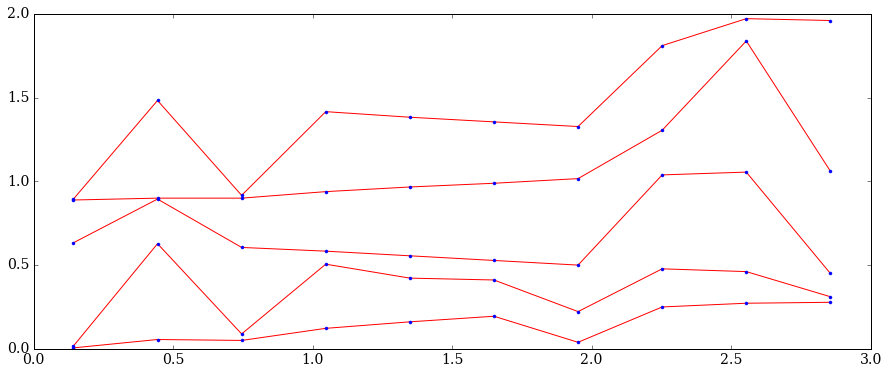

In [48]:
for i in range(n_w):
    w_k = [peaks[j][i] for j in range(n_k)]
    plt.plot(k, w_k, 'r')
    plt.plot(k, w_k, 'b.')
plt.show()